In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import import_ipynb
import ou_feature_engineering

import warnings
warnings.filterwarnings("ignore")

importing Jupyter notebook from ou_feature_engineering.ipynb


In [2]:
df = pd.read_excel('wideform.xlsx')

# Currently, the dataframe has "2" as final result when a student withdraws. 
# We're just looking at pass/not pass, so I'm changing those "2"s to "1"s (not pass)
df.loc[df['final_result'] == 2, 'final_result'] = 1

# Feature for change between sum_clicks
df['sum_clicks_change'] = df['sum_click_pre_A2'] / df['sum_click_pre_A1']

# Feature for whether student has taken other classes
df = ou_feature_engineering.add_col_student_prev_failed(df)


df.fillna(0, inplace=True)

df

Index(['id_student', 'code_module', 'code_presentation', 'final_result'], dtype='object')
Index(['code_module_x', 'code_presentation_x', 'id_student', 'gender',
       'highest_education', 'age_band', 'num_of_prev_attempts',
       'studied_credits', 'disability', 'final_result_x',
       ...
       'url_16-30', 'url_31-45', 'url_46-60', 'sum_click_pre_A1',
       'sum_click_pre_A2', 'sum_clicks_change', 'code_module_y',
       'code_presentation_y', 'final_result_y', 'prev_failed_or_withdrawn'],
      dtype='object', length=122)


,code_module,code_presentation,id_student,gender,highest_education,age_band,num_of_prev_attempts,studied_credits,disability,final_result,...,subpage_46-60,url_pre-0,url_1-15,url_16-30,url_31-45,url_46-60,sum_click_pre_A1,sum_click_pre_A2,sum_clicks_change,prev_failed_or_withdrawn
0,AAA,2013J,11391,0,3,2,0,240,0,0,...,0,0,1,0,0,0,352.0,175.0,0.497159,False
1,AAA,2013J,28400,1,3,1,0,60,0,0,...,1,10,9,11,1,1,493.0,156.0,0.316430,False
2,AAA,2013J,31604,1,2,1,0,60,0,0,...,3,3,10,8,12,3,390.0,371.0,0.951282,False
3,AAA,2013J,32885,1,1,0,0,60,0,0,...,1,3,0,3,0,0,558.0,64.0,0.114695,False
4,AAA,2013J,38053,0,2,1,0,60,0,0,...,3,1,4,6,2,3,614.0,395.0,0.643322,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22434,FFF,2014J,2684048,1,1,0,0,120,0,1,...,4,0,3,0,0,0,346.0,41.0,0.118497,False
22435,FFF,2014J,2686035,1,1,0,0,135,0,1,...,19,5,0,1,0,2,431.0,240.0,0.556845,False
22436,FFF,2014J,2693932,0,2,0,1,120,0,0,...,2,3,2,2,1,0,362.0,789.0,2.179558,False
22437,FFF,2014J,2694139,0,1,1,0,60,0,1,...,12,4,0,1,1,2,120.0,669.0,5.575000,False


In [3]:
df_a = df[df['code_module'] == 'AAA'] # 703 rows
df_b = df[df['code_module'] == 'BBB'] # 5974 rows
df_c = df[df['code_module'] == 'CCC'] # 2444 rows
df_d = df[df['code_module'] == 'DDD'] # 4822 rows
df_e = df[df['code_module'] == 'EEE'] # 2289 rows
df_f = df[df['code_module'] == 'FFF'] # 6207 rows

In [4]:
index_cols = ['code_module', 'code_presentation', 'id_student']
label = ['final_result']
# feature_cols is everything else

# I'm removing date_unregistration, that'll take more thought
not_features = ['code_module', 'code_presentation', 'id_student', 'final_result', 'date_unregistration']
features = [col for col in df.columns if col not in not_features]


In [5]:
def accuracy_by_module(module_df):
    X_train, X_test, y_train, y_test= train_test_split(module_df[features],module_df[label], test_size=0.20)

    y_train = y_train.astype('int').to_numpy().ravel()
    y_test = y_test.astype('int').to_numpy().ravel()

    clf = RandomForestClassifier(n_estimators = 1000, random_state=42)
    clf.fit(X_train, y_train)

    score = clf.score(X_test, y_test)
    importances = list(clf.feature_importances_)
    feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(features, importances)]
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

    probabilities = clf.predict_proba(module_df[features])[:,1]
    module_df['probability'] = clf.predict_proba(module_df[features])[:,1]

    return score, feature_importances, module_df
    
    

In [6]:
a_score, a_top, a_with_proba = accuracy_by_module(df_a)
b_score, b_top, b_with_proba = accuracy_by_module(df_b)
c_score, c_top, c_with_proba = accuracy_by_module(df_c)
d_score, d_top, d_with_proba = accuracy_by_module(df_d)
e_score, e_top, e_with_proba = accuracy_by_module(df_e)
f_score, f_top, f_with_proba = accuracy_by_module(df_f)

full_score, full_top, full_with_proba = accuracy_by_module(df)

In [7]:
print(a_score)
print(b_score)
print(c_score)
print(d_score)
print(e_score)
print(f_score)
print("---")
print(full_score)

0.8865248226950354
0.7556485355648536
0.8016359918200409
0.7523316062176166
0.7925764192139738
0.7616747181964574
---
0.7720588235294118


In [8]:
a_top[:10]

[('score_A2', 0.0782),
 ('weighted_score_A2', 0.075),
 ('days_from_due_A2', 0.0585),
 ('date_submitted_A2', 0.0566),
 ('score_A1', 0.0342),
 ('weighted_score_A1', 0.0326),
 ('date_registration', 0.0291),
 ('sum_clicks_change', 0.0288),
 ('oucontent_31-45', 0.0284),
 ('sum_click_pre_A2', 0.0256)]

In [9]:
b_top[:10]

[('score_A2', 0.0854),
 ('weighted_score_A2', 0.0663),
 ('days_from_due_A2', 0.0635),
 ('date_submitted_A2', 0.0554),
 ('homepage_46-60', 0.0339),
 ('sum_click_pre_A2', 0.0304),
 ('homepage_31-45', 0.0277),
 ('sum_clicks_change', 0.0269),
 ('score_A1', 0.0261),
 ('sum_click_pre_A1', 0.0242)]

In [10]:
c_top[:10]

[('weighted_score_A2', 0.1162),
 ('score_A2', 0.1149),
 ('days_from_due_A2', 0.0712),
 ('date_submitted_A2', 0.0555),
 ('score_A1', 0.0533),
 ('weighted_score_A1', 0.0464),
 ('sum_click_pre_A2', 0.0447),
 ('sum_clicks_change', 0.0409),
 ('homepage_46-60', 0.0201),
 ('sum_click_pre_A1', 0.0189)]

In [11]:
d_top[:10]

[('score_A2', 0.0847),
 ('weighted_score_A2', 0.0801),
 ('score_A1', 0.049),
 ('days_from_due_A2', 0.0375),
 ('date_submitted_A2', 0.0372),
 ('homepage_46-60', 0.0277),
 ('forumng_46-60', 0.0247),
 ('sum_click_pre_A2', 0.0245),
 ('weighted_score_A1', 0.0239),
 ('homepage_31-45', 0.0214)]

In [12]:
e_top[:10]

[('weighted_score_A2', 0.0999),
 ('score_A2', 0.0939),
 ('days_from_due_A2', 0.0716),
 ('date_submitted_A2', 0.0677),
 ('sum_click_pre_A2', 0.0375),
 ('score_A1', 0.0372),
 ('weighted_score_A1', 0.0351),
 ('sum_clicks_change', 0.0315),
 ('oucontent_46-60', 0.0269),
 ('homepage_46-60', 0.0241)]

In [13]:
f_top[:10]

[('weighted_score_A2', 0.0768),
 ('score_A2', 0.0758),
 ('date_submitted_A2', 0.042),
 ('days_from_due_A2', 0.0409),
 ('homepage_46-60', 0.0323),
 ('sum_click_pre_A2', 0.0294),
 ('oucontent_46-60', 0.0274),
 ('subpage_46-60', 0.0256),
 ('oucontent_31-45', 0.0246),
 ('homepage_31-45', 0.0236)]

In [14]:
full_top[:10]

[('score_A2', 0.0973),
 ('weighted_score_A2', 0.0833),
 ('date_submitted_A2', 0.0508),
 ('days_from_due_A2', 0.0505),
 ('score_A1', 0.0353),
 ('sum_click_pre_A2', 0.0292),
 ('homepage_46-60', 0.0279),
 ('sum_clicks_change', 0.0256),
 ('homepage_31-45', 0.0231),
 ('days_from_due_A1', 0.0196)]

In [15]:
a_with_proba

,code_module,code_presentation,id_student,gender,highest_education,age_band,num_of_prev_attempts,studied_credits,disability,final_result,...,url_pre-0,url_1-15,url_16-30,url_31-45,url_46-60,sum_click_pre_A1,sum_click_pre_A2,sum_clicks_change,prev_failed_or_withdrawn,probability
0,AAA,2013J,11391,0,3,2,0,240,0,0,...,0,1,0,0,0,352.0,175.0,0.497159,False,0.065
1,AAA,2013J,28400,1,3,1,0,60,0,0,...,10,9,11,1,1,493.0,156.0,0.316430,False,0.080
2,AAA,2013J,31604,1,2,1,0,60,0,0,...,3,10,8,12,3,390.0,371.0,0.951282,False,0.026
3,AAA,2013J,32885,1,1,0,0,60,0,0,...,3,0,3,0,0,558.0,64.0,0.114695,False,0.268
4,AAA,2013J,38053,0,2,1,0,60,0,0,...,1,4,6,2,3,614.0,395.0,0.643322,False,0.104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698,AAA,2014J,2680312,0,3,2,0,60,0,0,...,3,20,20,12,10,791.0,866.0,1.094817,False,0.091
699,AAA,2014J,2688166,0,1,1,0,60,0,0,...,0,13,5,2,4,276.0,206.0,0.746377,False,0.049
700,AAA,2014J,2690062,1,2,1,0,120,0,1,...,0,2,2,0,0,227.0,30.0,0.132159,False,0.894
701,AAA,2014J,2692514,0,1,1,0,120,0,0,...,0,0,0,0,0,1743.0,1372.0,0.787149,False,0.079


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000299BB231AC0>]],
      dtype=object)

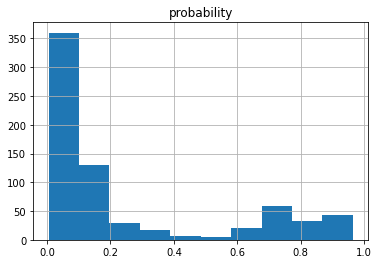

In [16]:
a_with_proba.hist(column='probability')

In [21]:
generalized_predictions_df = full_with_proba[['code_module', 'code_presentation', 'id_student', 'probability']].copy()

predictions_df.head(5)

,code_module,code_presentation,id_student,probability
0,AAA,2013J,11391,0.080
1,AAA,2013J,28400,0.088
2,AAA,2013J,31604,0.020
3,AAA,2013J,32885,0.229
4,AAA,2013J,38053,0.081


In [24]:
a_prob_df = a_with_proba[['code_module', 'code_presentation', 'id_student', 'probability']].copy()
b_prob_df = b_with_proba[['code_module', 'code_presentation', 'id_student', 'probability']].copy()
c_prob_df = c_with_proba[['code_module', 'code_presentation', 'id_student', 'probability']].copy()
d_prob_df = d_with_proba[['code_module', 'code_presentation', 'id_student', 'probability']].copy()
e_prob_df = e_with_proba[['code_module', 'code_presentation', 'id_student', 'probability']].copy()
f_prob_df = f_with_proba[['code_module', 'code_presentation', 'id_student', 'probability']].copy()

class_specific_predictions = pd.concat([a_prob_df, b_prob_df, c_prob_df, d_prob_df, e_prob_df, f_prob_df], ignore_index=True)
class_specific_predictions

,code_module,code_presentation,id_student,probability
0,AAA,2013J,11391,0.065
1,AAA,2013J,28400,0.080
2,AAA,2013J,31604,0.026
3,AAA,2013J,32885,0.268
4,AAA,2013J,38053,0.104
...,...,...,...,...
22434,FFF,2014J,2684048,0.982
22435,FFF,2014J,2686035,0.790
22436,FFF,2014J,2693932,0.076
22437,FFF,2014J,2694139,0.638


In [26]:
# Uncomment this code to re-save predictions

#generalized_predictions_df.to_excel("generalized_predicts.xlsx", index=False)
#class_specific_predictions.to_excel("class_specific_predicts.xlsx", index=False)